<a href="https://www.kaggle.com/code/dascient/unidentified-anomalous-phenomena-a-deep-dive?scriptVersionId=126691874" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# NUFORC Data Exploitation 🧮AI-ML-DS📊 & More to Come🪐
## 🔭Research, 📈Analysis, 🌌A Multiversal Collaborative Effort of Investigating Something More Extraordinary Than Ourselves, & 🤖Pure Enjoyment

### An attempt to exploit NUFORC's public 📘 reports of first-hand sightings/experiences of [Anomalous Phenomena](https://en.wikipedia.org/wiki/Association_for_the_Scientific_Study_of_Anomalous_Phenomena). Please see [NUFORC](https://nuforc.org/databank/)'s webpage to get a better understanding of the nature of the data. 


#### This project is also very much a work-in-progress. We intend to leverage other public/open-source databases to further our research (i.e. 🛩️commercial air traffic data, 🚁multi-domain track-correlation analysis, and so on) & investigative methods by aiming to aggregate pertinent resources that will serve to augment reproducible scalability of it's applications & the overall *purpose* of our ultimate mission. 

### See Contributors & Collaborators below.

## 🛥️Ultimate Mission🛩️
To provide a proof-of-concept of an all-domain analytic effort that would address [national priority needs](https://en.m.wikipedia.org/wiki/National_Intelligence_Priorities_Framework#:~:text=The%20National%20Intelligence%20Priorities%20Framework,summarizes%20the%20United%20States%27s%20intelligence) of the [ODNI](https://www.dni.gov/files/ODNI/documents/assessments/Unclassified-2022-Annual-Report-UAP.pdf)'s rising [AARO](https://en.m.wikipedia.org/wiki/All-domain_Anomaly_Resolution_Office)-focused mandates & delegations spread throughout the IC in support of this particular subject matter - as well as what may come forth beyond it's research & potentially disruptive scientific discoveries.

We also aim to provide insights derived from the latest [JWST](https://webb.nasa.gov/) research & findings, as we cannot philosophicaly rule out the idea that we are alone. We hope to uncover the idea that, in fact, "...we are a part of the norm - we are not an exception." -[C. Mellon](https://www.christophermellon.net), Former DASDI. 

#### *I hope this serves something delightful.*

#  Load our packages & NUFORC's 80K dataset as a csv.

In [2]:
# This Python 3 Analysis of NUFORC's database contains 80,0000 rows of reported sightings. 
# I'm so glad this one came with Lat/Long,s for me to play with.

# for the sake of expeditious analysis
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from wordcloud import WordCloud, STOPWORDS
from geopandas import GeoDataFrame
import matplotlib.colors as colors
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# settings
pd.set_option('display.max_columns', 50)
plt.rcParams["xtick.labelsize"] = 2

/kaggle/input/ufo-sightings/ufos.csv


# What does the data look like?

#### Typical reporting-type dataset - City, State, Shapes seen, Observation duration, geolocation.

##### For now, disregard column 'verified'. It is a randomly generated (1,6) vector that will later be used to prove AI-ML modeling.

In [3]:
# loading...
og_df = pd.read_csv('/kaggle/input/ufo-sightings/ufos.csv',header=0)
df = og_df.dropna().copy()

# sanitize
# drop some columns, for now
df = df.drop(columns=['datetime','duration (hours/min)'])

# date posted deemed to be easily conveible to timestamp values, so i'm gonna work with that for now.
df['date posted'] = df['date posted'].astype('datetime64[ns]')


# lowercase all comments
df['comments'] = df['comments'].str.lower()

# length of comments
df['comment_length'] = [len(str(v)) for i,v in df.comments.items()]

# convert seconds to minutes
df["duration (minutes)"] = [int(v)/60 for i,v in df["duration (seconds)"].items()]

# let's create subsets of our 80,000 here: 
# we can implement conditionals, remove/analyze outliers, 
# & will enable for back referencing when starting to run 
# robust AI-ML modeling that would otherwise take much longer to run.

# let's create subsets from the main dataframe/reporting-data w/ respect to duration of observations
df_under100 = df[df["duration (minutes)"]<100]
df_under60 = df[df["duration (minutes)"]<60]

# random binary column for future AI-ML modeling.
df['verified'] = np.random.randint(1,4,df.shape[0])

# shape-focused
circles = df[df['shape'] == 'circle']
lights = df[df['shape'] == 'light']
teardrops = df[df['shape'] == 'teardrop']

# year-month
df['year_month'] = df['date posted'].dt.to_period('M')

# show
print("\nReports: non-null dataframe")
print("\nMatrix",df.shape)
df.sort_values('date posted',ascending=False).reset_index(drop=True)


Reports: non-null dataframe

Matrix (66516, 13)


city state country     shape  duration (seconds)  \
0            liberty    sc      us      oval              3600.0   
1            lombard    il      us    circle                20.0   
2      crescent city    ca      us   unknown               300.0   
3             canton    oh      us    sphere                30.0   
4               york    sc      us  changing               180.0   
...              ...   ...     ...       ...                 ...   
66511   harrisonburg    va      us     light                60.0   
66512        bastrop    la      us     light              3600.0   
66513         juneau    ak      us     light              7200.0   
66514       scranton    ks      us  fireball                45.0   
66515   new brighton    mn      us  triangle              2700.0   

                                                comments date posted  \
0            possible u.f.o. sighting in liberty&#44 sc.  2014-05-08   
1      bright red &amp; yellow colored ball flying we...  2014-05-08   
2      large&#44 bright object straight up and very h...  2014-05-08   
3      i saw a small fuzzy gray sphere fly in the sky...  2014-05-08   
4                                            fast moving  2014-05-08   
...                                                  ...         ...   
66511  five stationary lights in a row in the southea...  1998-03-07   
66512  due south of bastropa bright light was seen in...  1998-03-07   
66513  a friend and i saw a strange low altitudebrigh...  1998-03-07   
66514  my son and i saw a something slowly falling ou...  1998-03-07   
66515  20-35 triangular shaped craft sighting.bright ...  1998-03-07   

        latitude   longitude  comment_length  duration (minutes)  verified  \
0      34.787778  -82.692500              43           60.000000         3   
1      41.880000  -88.007778              76            0.333333         2   
2      41.756111 -124.200556             114            5.000000         3   
3      40.798889  -81.378611              82            0.500000         3   
4      34.994167  -81.242222              11            3.000000         1   
...          ...         ...             ...                 ...       ...   
66511  38.449444  -78.869167              55            1.000000         1   
66512  32.756111  -91.872222             134           60.000000         2   
66513  58.301944 -134.419722             137          120.000000         1   
66514  38.781667  -95.738333             134            0.750000         1   
66515  45.065556  -93.201667              73           45.000000         2   

      year_month  
0        2014-05  
1        2014-05  
2        2014-05  
3        2014-05  
4        2014-05  
...          ...  
66511    1998-03  
66512    1998-03  
66513    1998-03  
66514    1998-03  
66515    1998-03  

[66516 rows x 13 columns]

## Top 20 Shapes

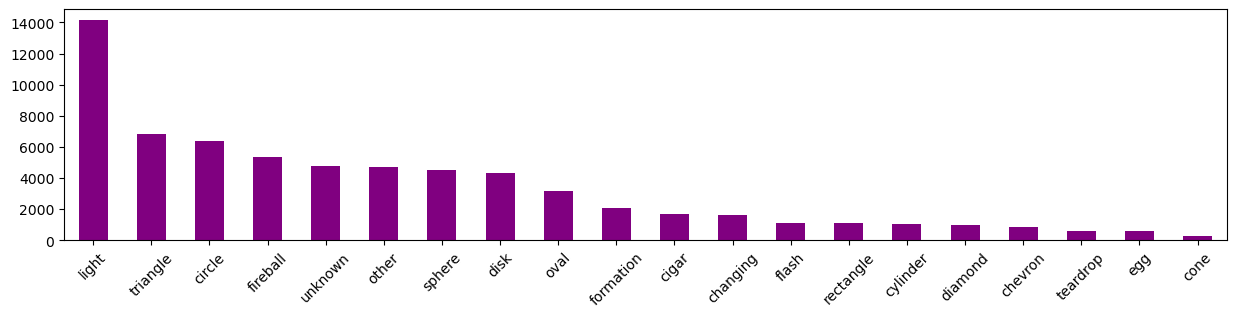

In [4]:
df['shape'].value_counts().head(20).plot(kind='bar',figsize=(15,3),color='purple')
plt.xticks(rotation=45)
plt.show()

## Top 20 Cities

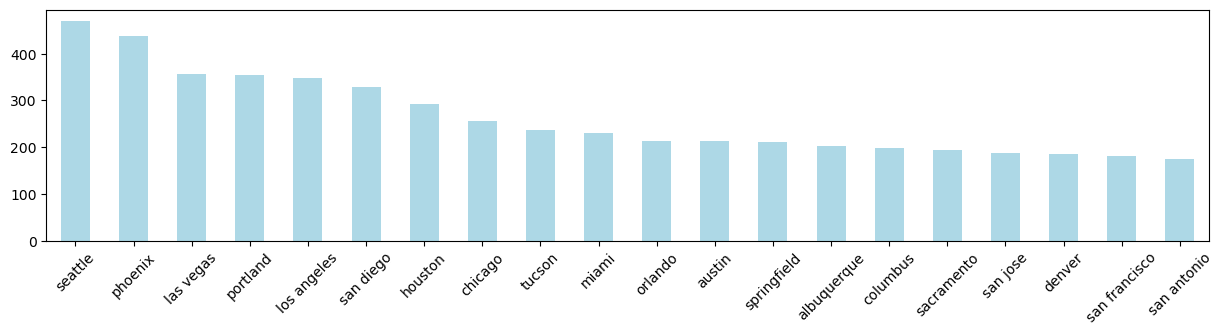

In [5]:
df['city'].value_counts().head(20).plot(kind='bar',figsize=(15,3),color='lightblue')
plt.xticks(rotation=45)
plt.show()

## Top 20 Comments

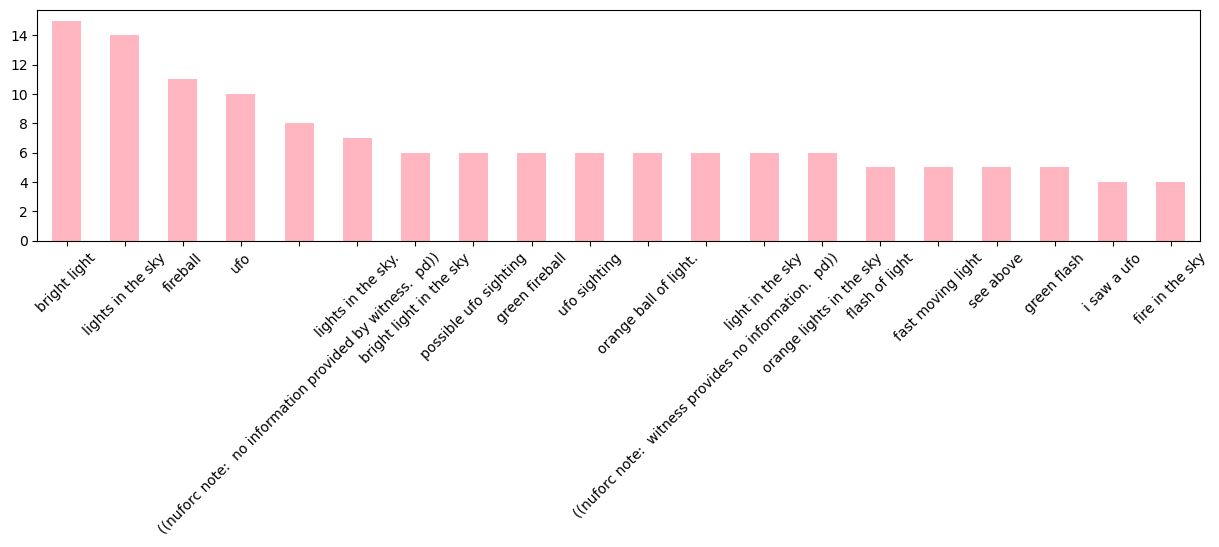

In [6]:
df['comments'].value_counts().head(20).plot(kind='bar',figsize=(15,3),color='lightpink')
plt.xticks(rotation=45)
plt.show()

## Top 20 Comment Lengths

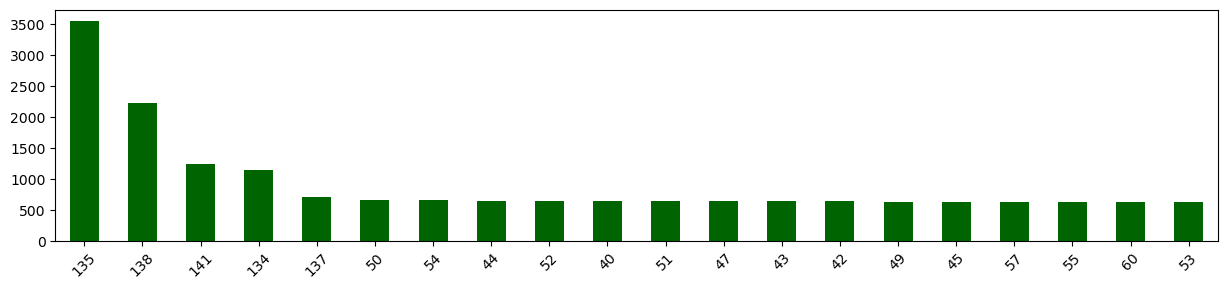

In [7]:
df['comment_length'].value_counts().head(20).plot(kind='bar',figsize=(15,3),color='darkgreen')
plt.xticks(rotation=45)
plt.show()

## Duration, Lat, Lon - numerical insight.



In [8]:
df.describe().style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '12px'})

#### Average duration of sighting: 6572.996774 seconds, or 109.549923 mins. 

#### The Lat/Lon: 72.700000,153.099533 - may or may not be significant. We'll see later.

# Analysis

## Seaborn - CatPlot
This is a sample of 500 of the 80,0000 observations - Duration under 60 minutes. 

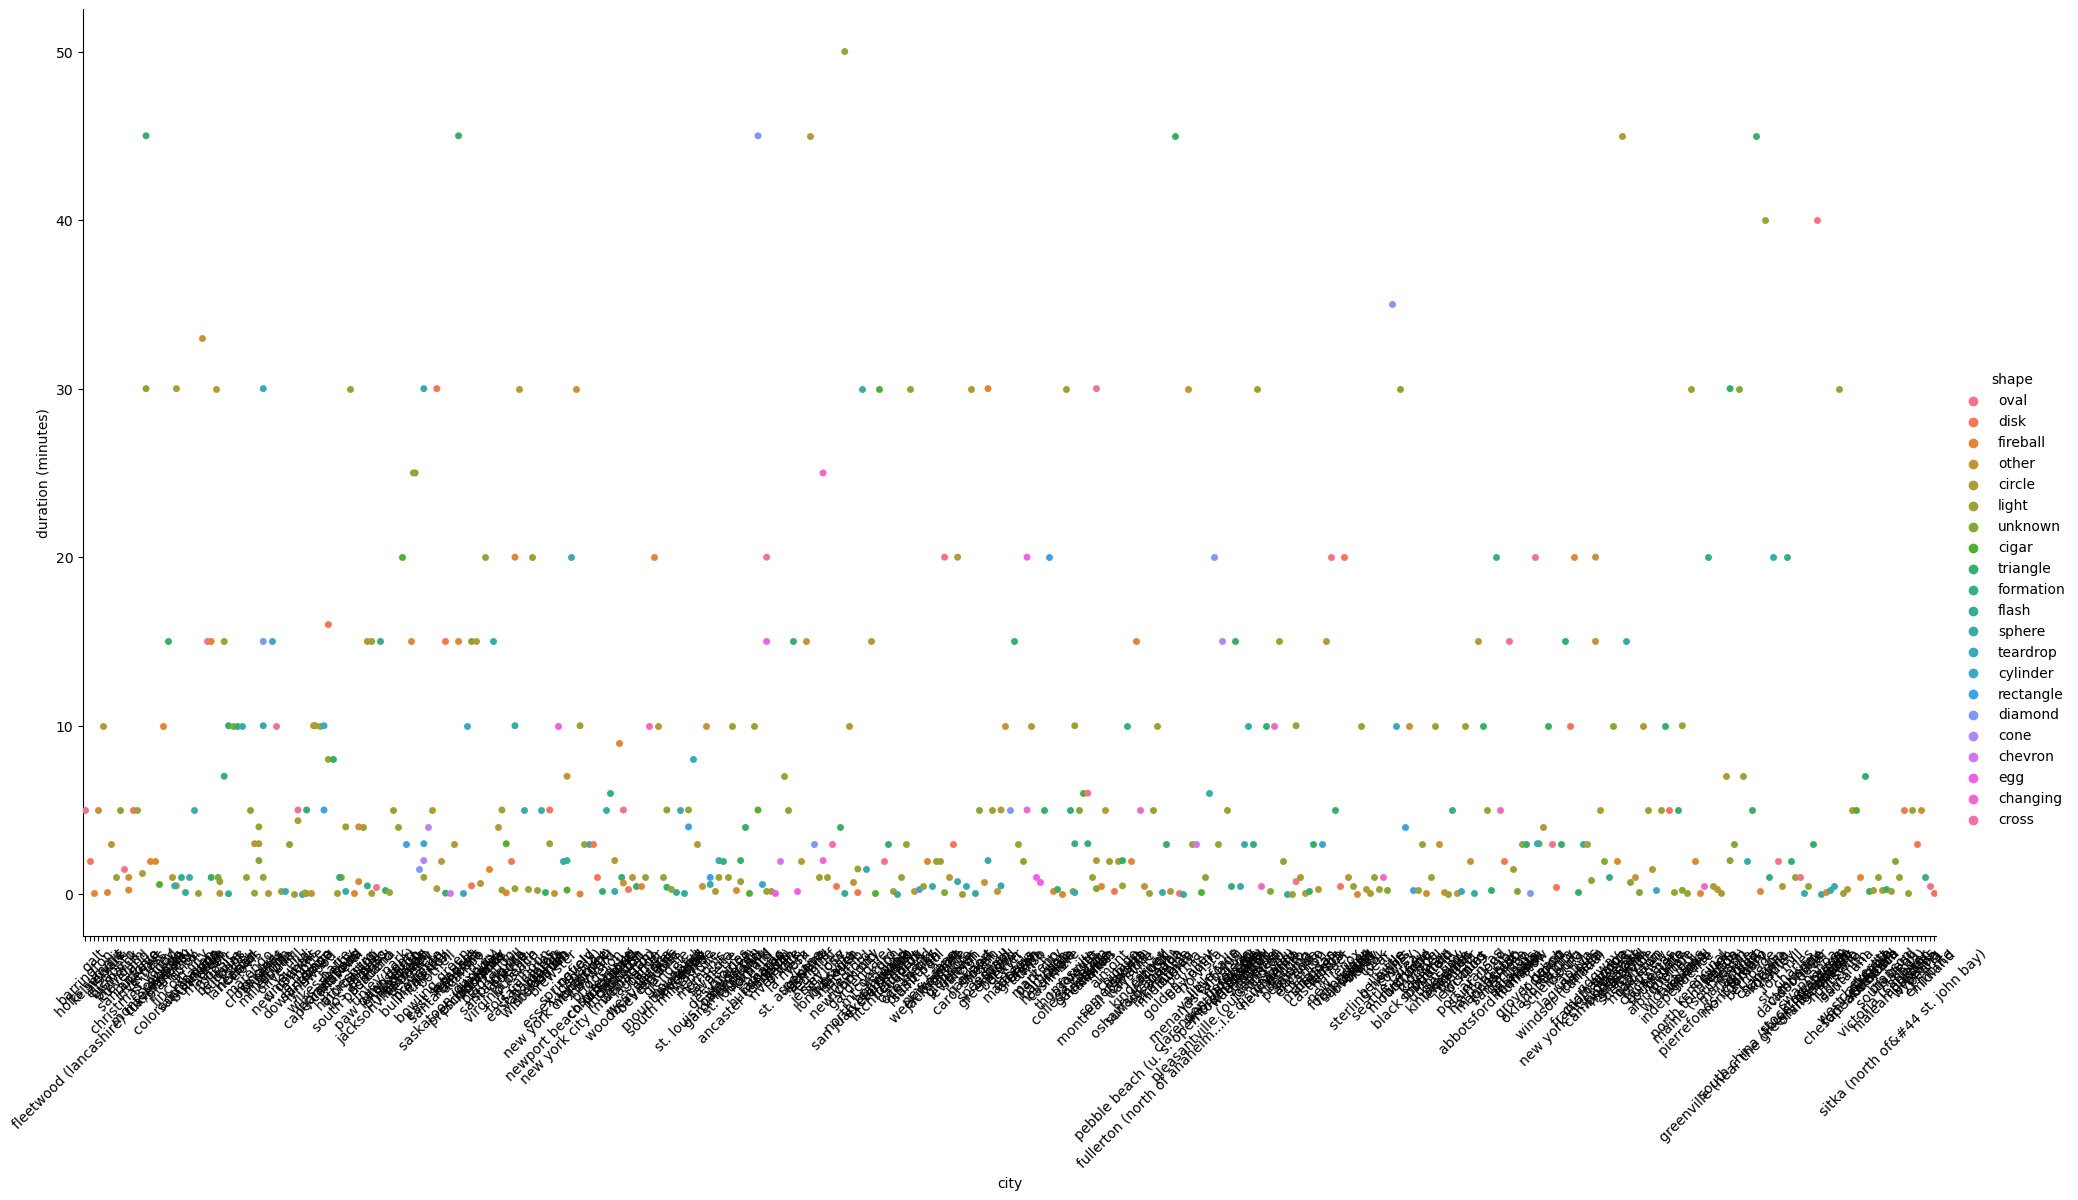

In [9]:
# plot a sample of 100 observations that lasted under 60 minutes
# need to get a smaller sample of city-set, the x-axis is way too muddled.
sns.catplot(data=df_under60.sample(500), x="city", y="duration (minutes)", hue="shape", kind="swarm", height=10, aspect=2)
plt.xticks(rotation=45)
plt.show()

This is a sample of 500 observations of only shape identified as "lights".

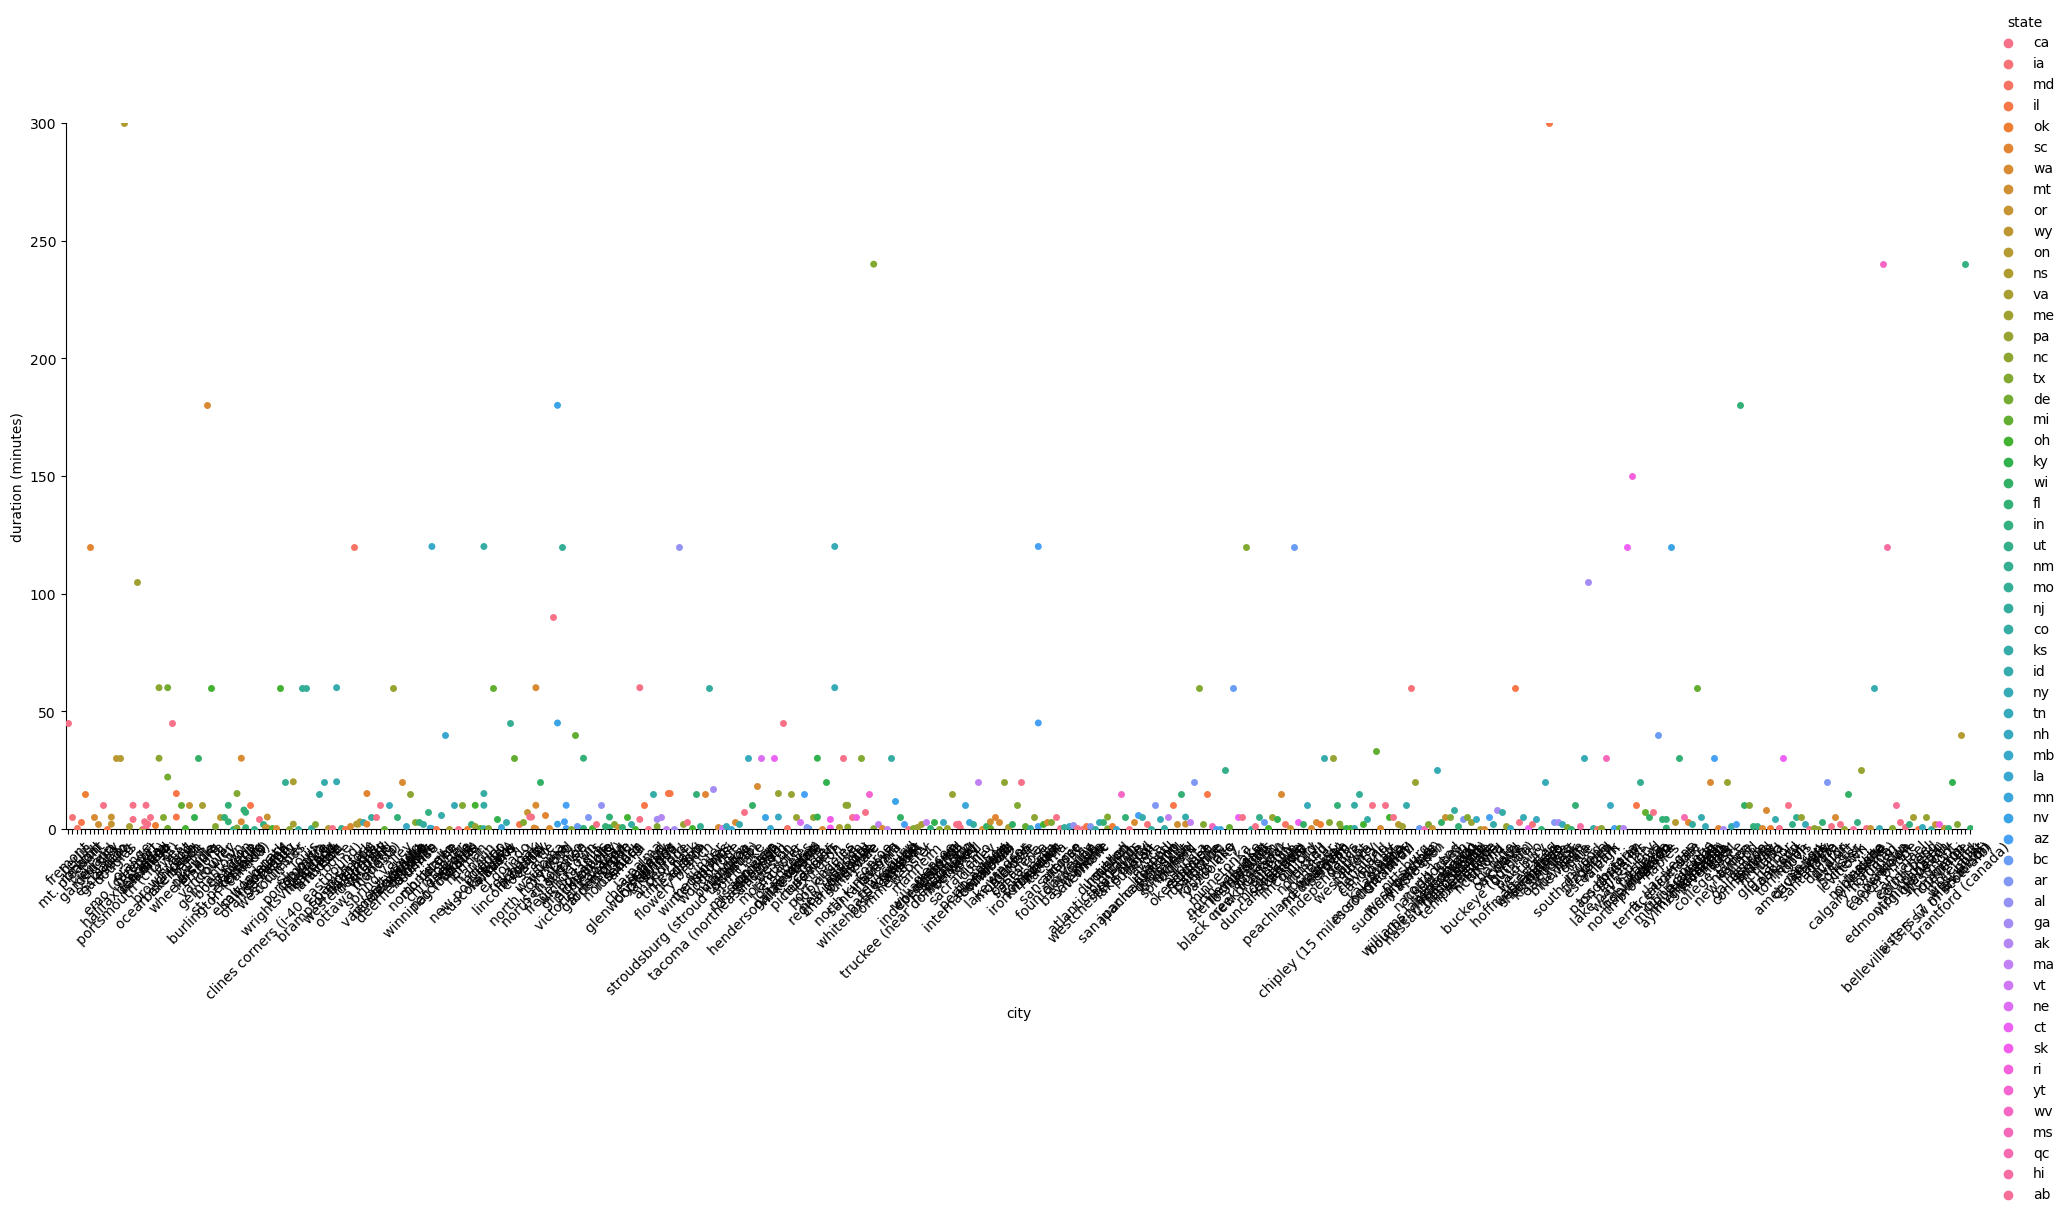

In [10]:
# plot a sample of 100 observations that lasted under 60 minutes
# need to get a smaller sample of city-set, the x-axis is way too muddled.
sns.catplot(data=lights.sample(500), x="city", y="duration (minutes)", hue="state", kind="swarm", height=10, aspect=2)
plt.xticks(rotation=45)
plt.ylim(top=300)
plt.ylim(bottom=0)
plt.show()

This graph uses the "duration (minutes)" values as the x-axis &  "state" as y-axis.

Varying colors represent the object's shape. 10,000 of 80,000 observations.

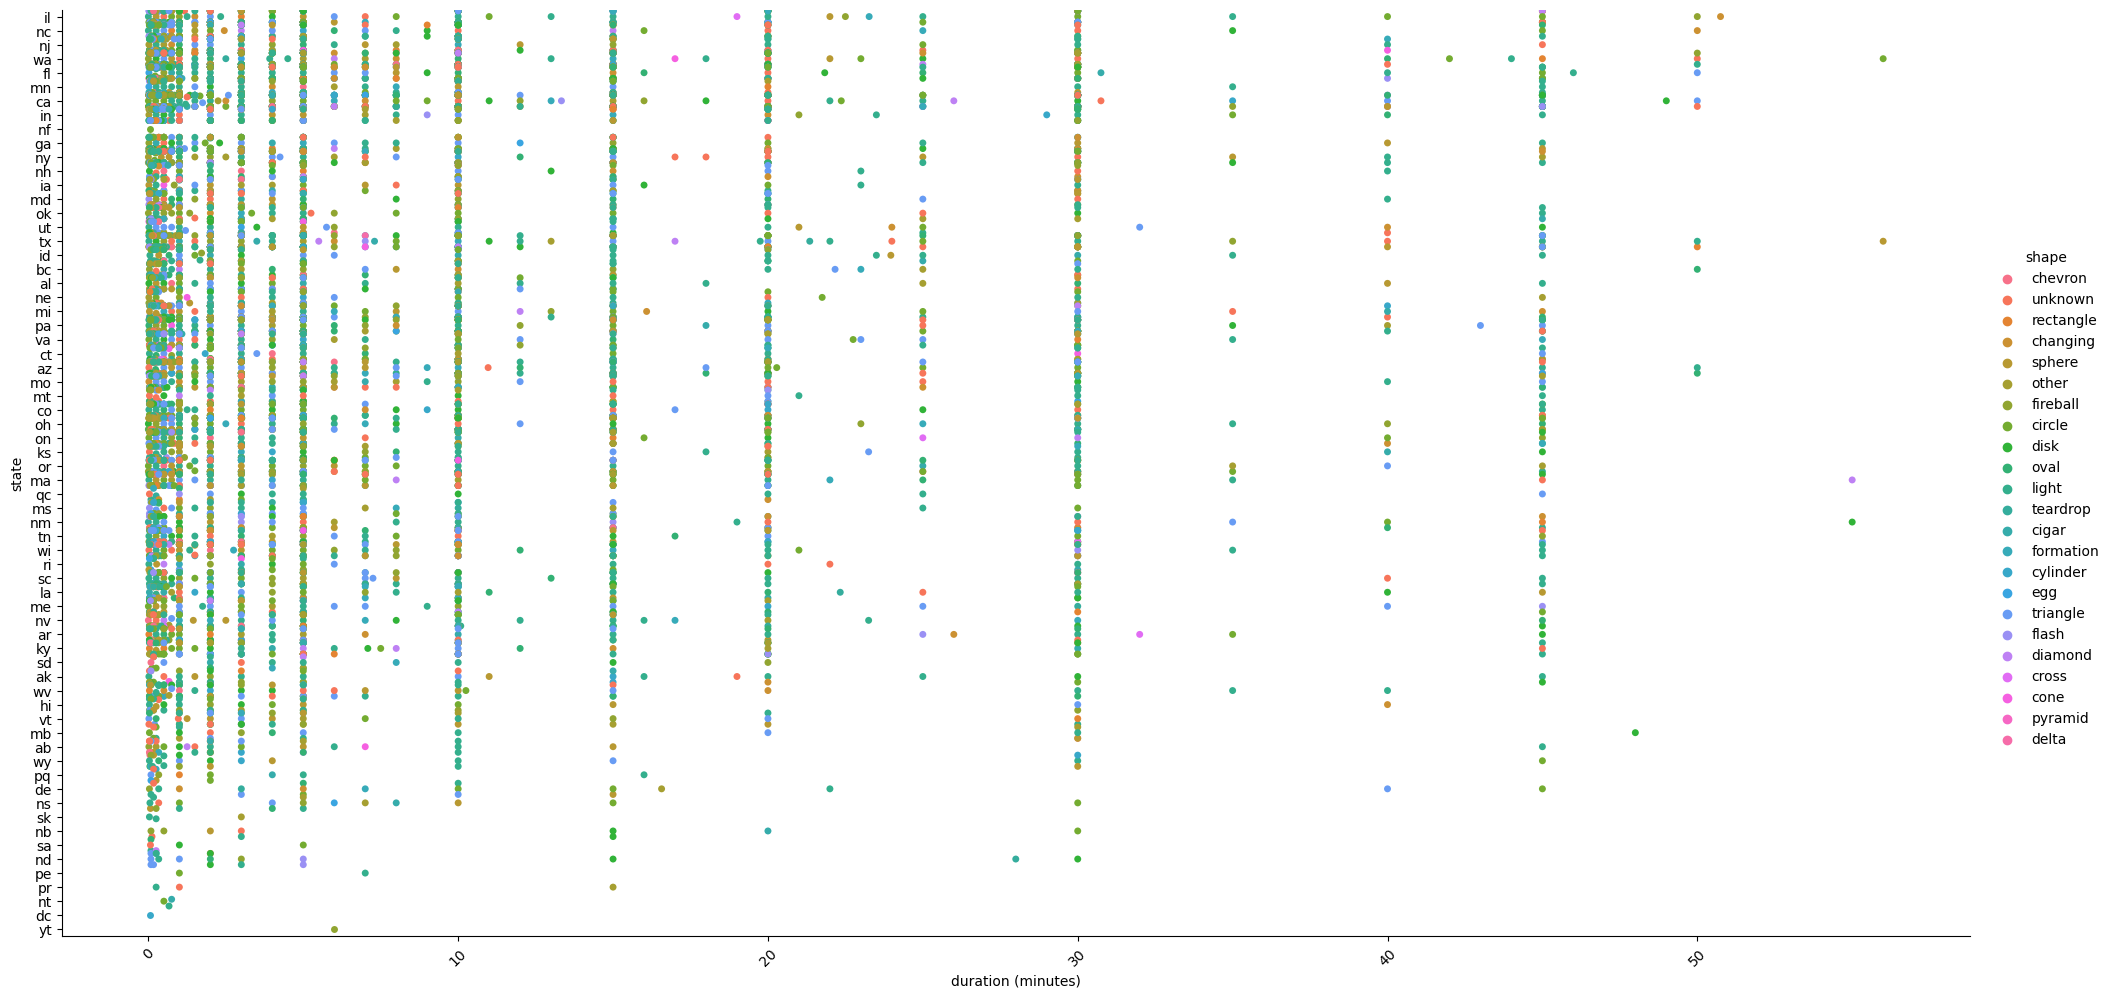

In [11]:
# i think i like the "duration" set as the x-axis & y-axis as "state", instead...
# & let's try for 10000 observations this time...
sns.catplot(data=df_under60.sample(10000), x="duration (minutes)", y="state", hue="shape", kind="swarm", height=10, aspect=2)
plt.xticks(rotation=45)
plt.show()

In [12]:
# set plot margin limits
#plt.xlim(right=xmax) #xmax is your value
#plt.xlim(left=xmin) #xmin is your value
#plt.ylim(top=ymax) #ymax is your value
#plt.ylim(bottom=ymin) #ymin is your value

## CatPlot•GeoPandas

All sightings on map. Categorized by shape.

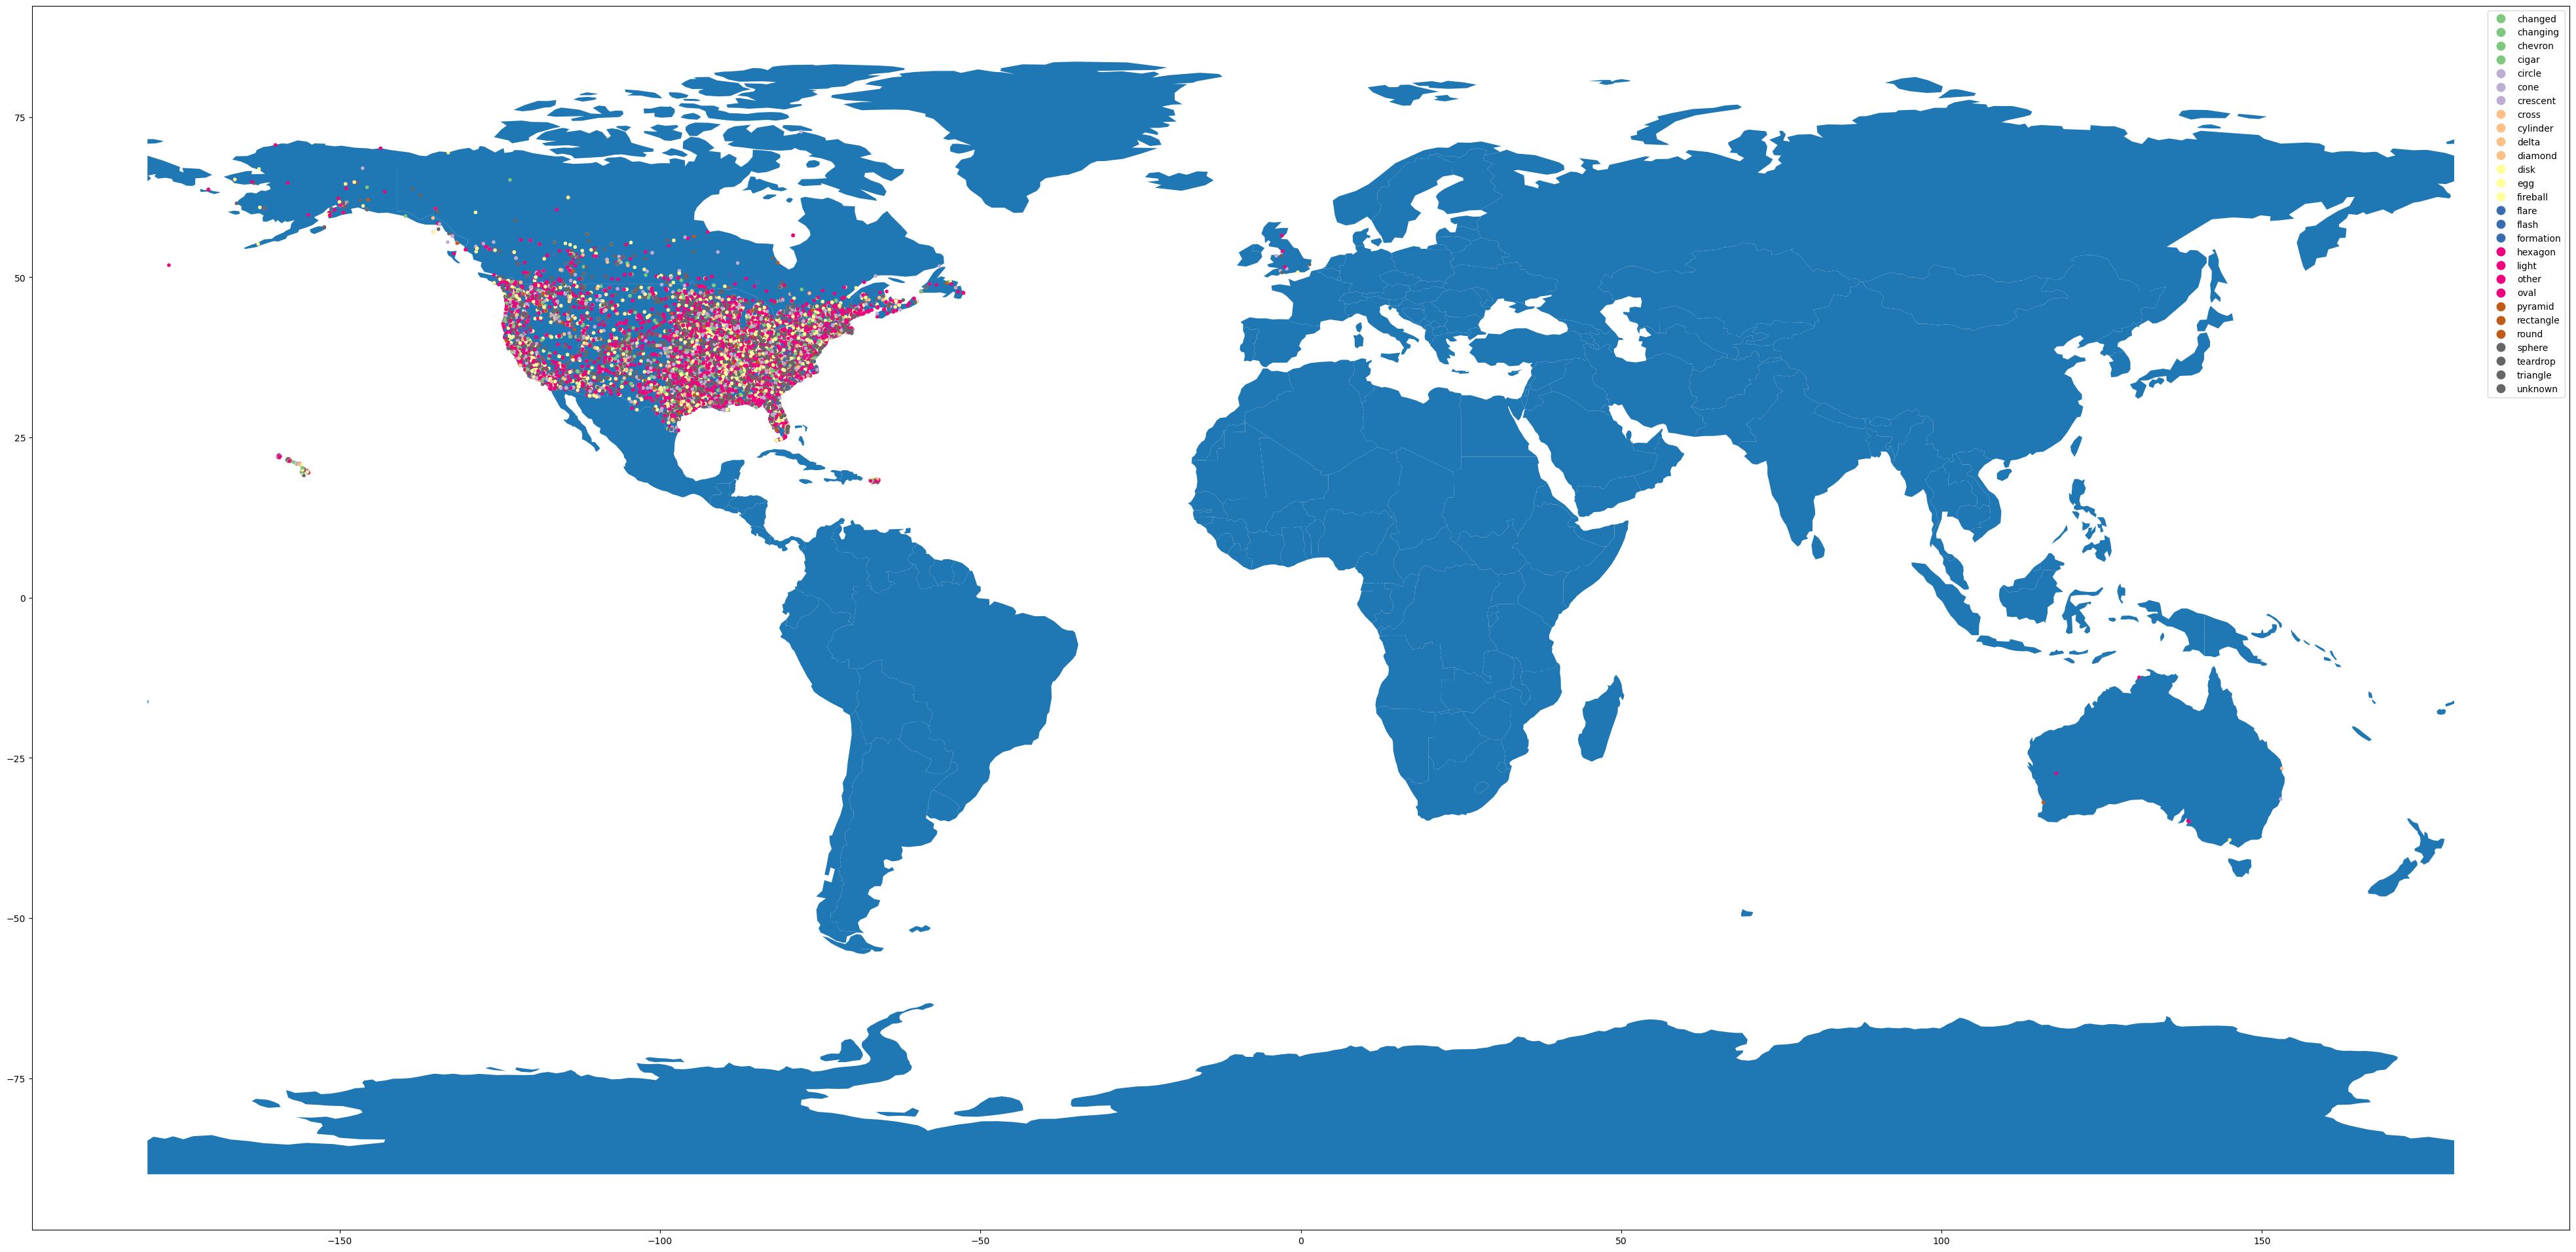

In [13]:
# geopandas
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

# This is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(50, 25)), marker='o', column='shape', cmap='Accent', markersize=9, legend=True);

This only shows those that were reported shape as "lights".  Categorized by length of comments.

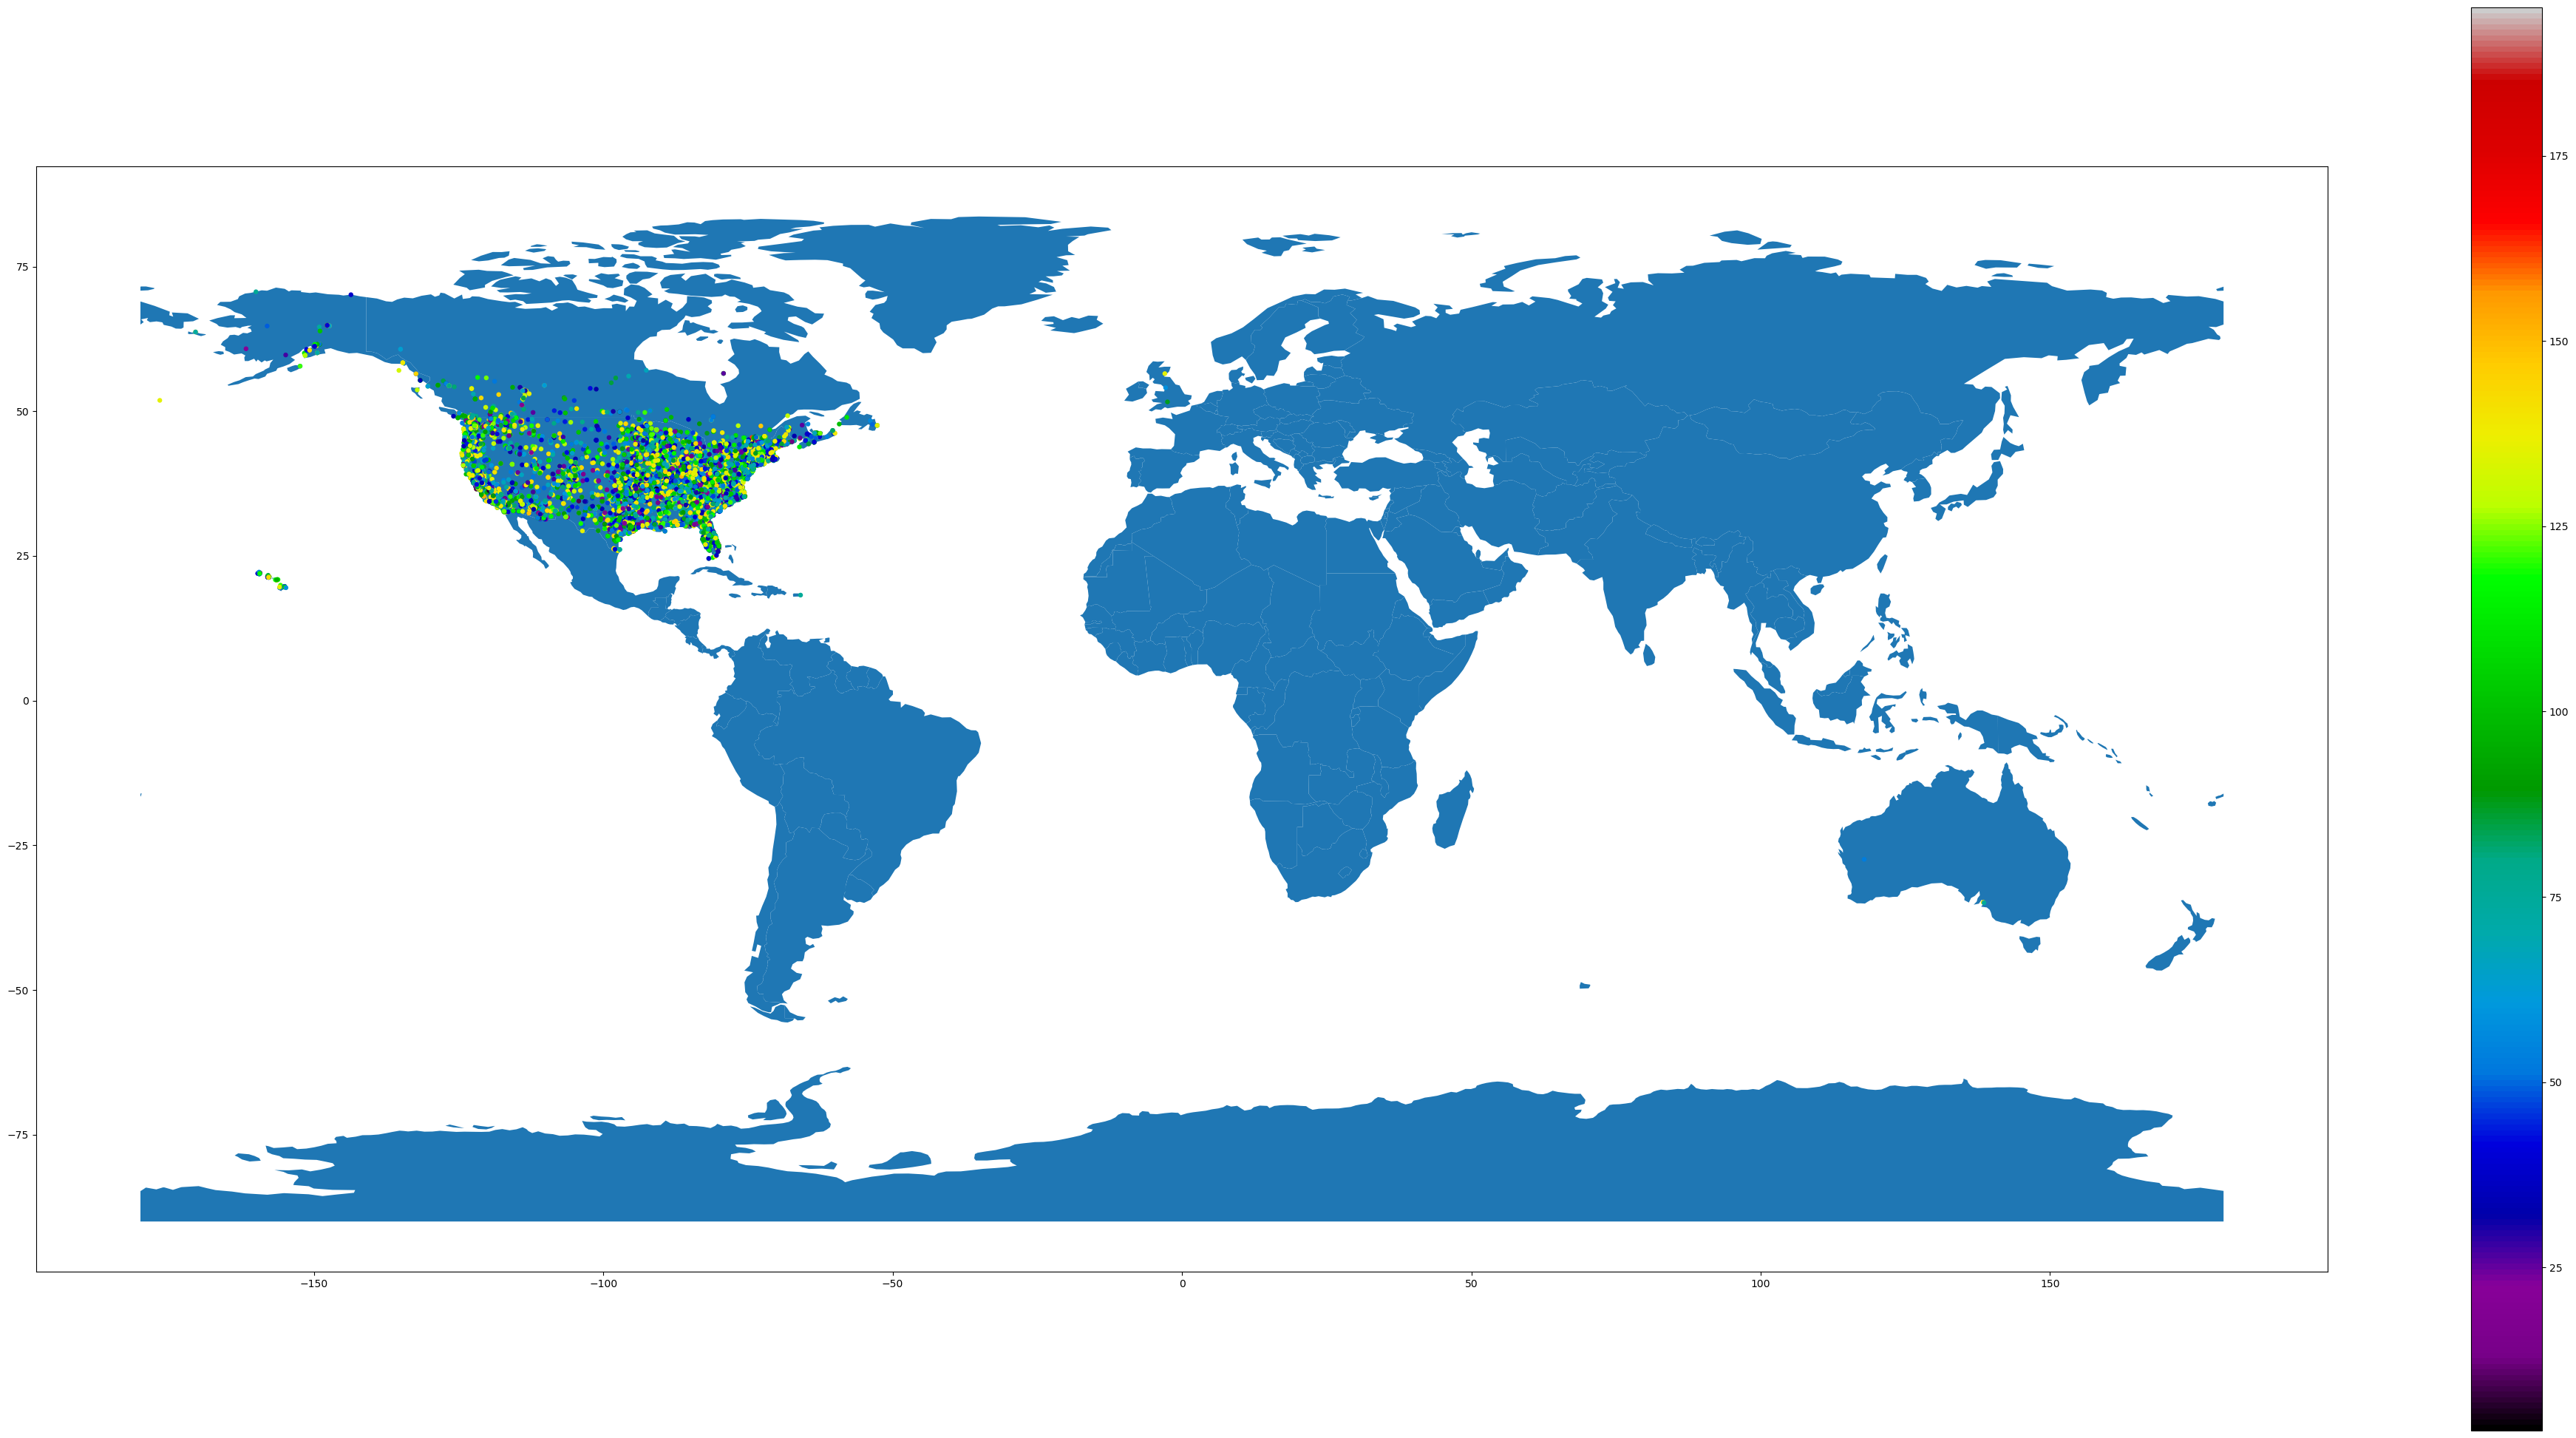

In [14]:
# lights

# geopandas - using subset data above
geometry = [Point(xy) for xy in zip(lights['longitude'], lights['latitude'])]
gdf = GeoDataFrame(lights, geometry=geometry)   

# This is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(50, 25)), marker='o', column='comment_length', cmap='nipy_spectral', markersize=13, legend=True);

This only shows those that were reported shape as "teardrops". Categorized by length of comments.

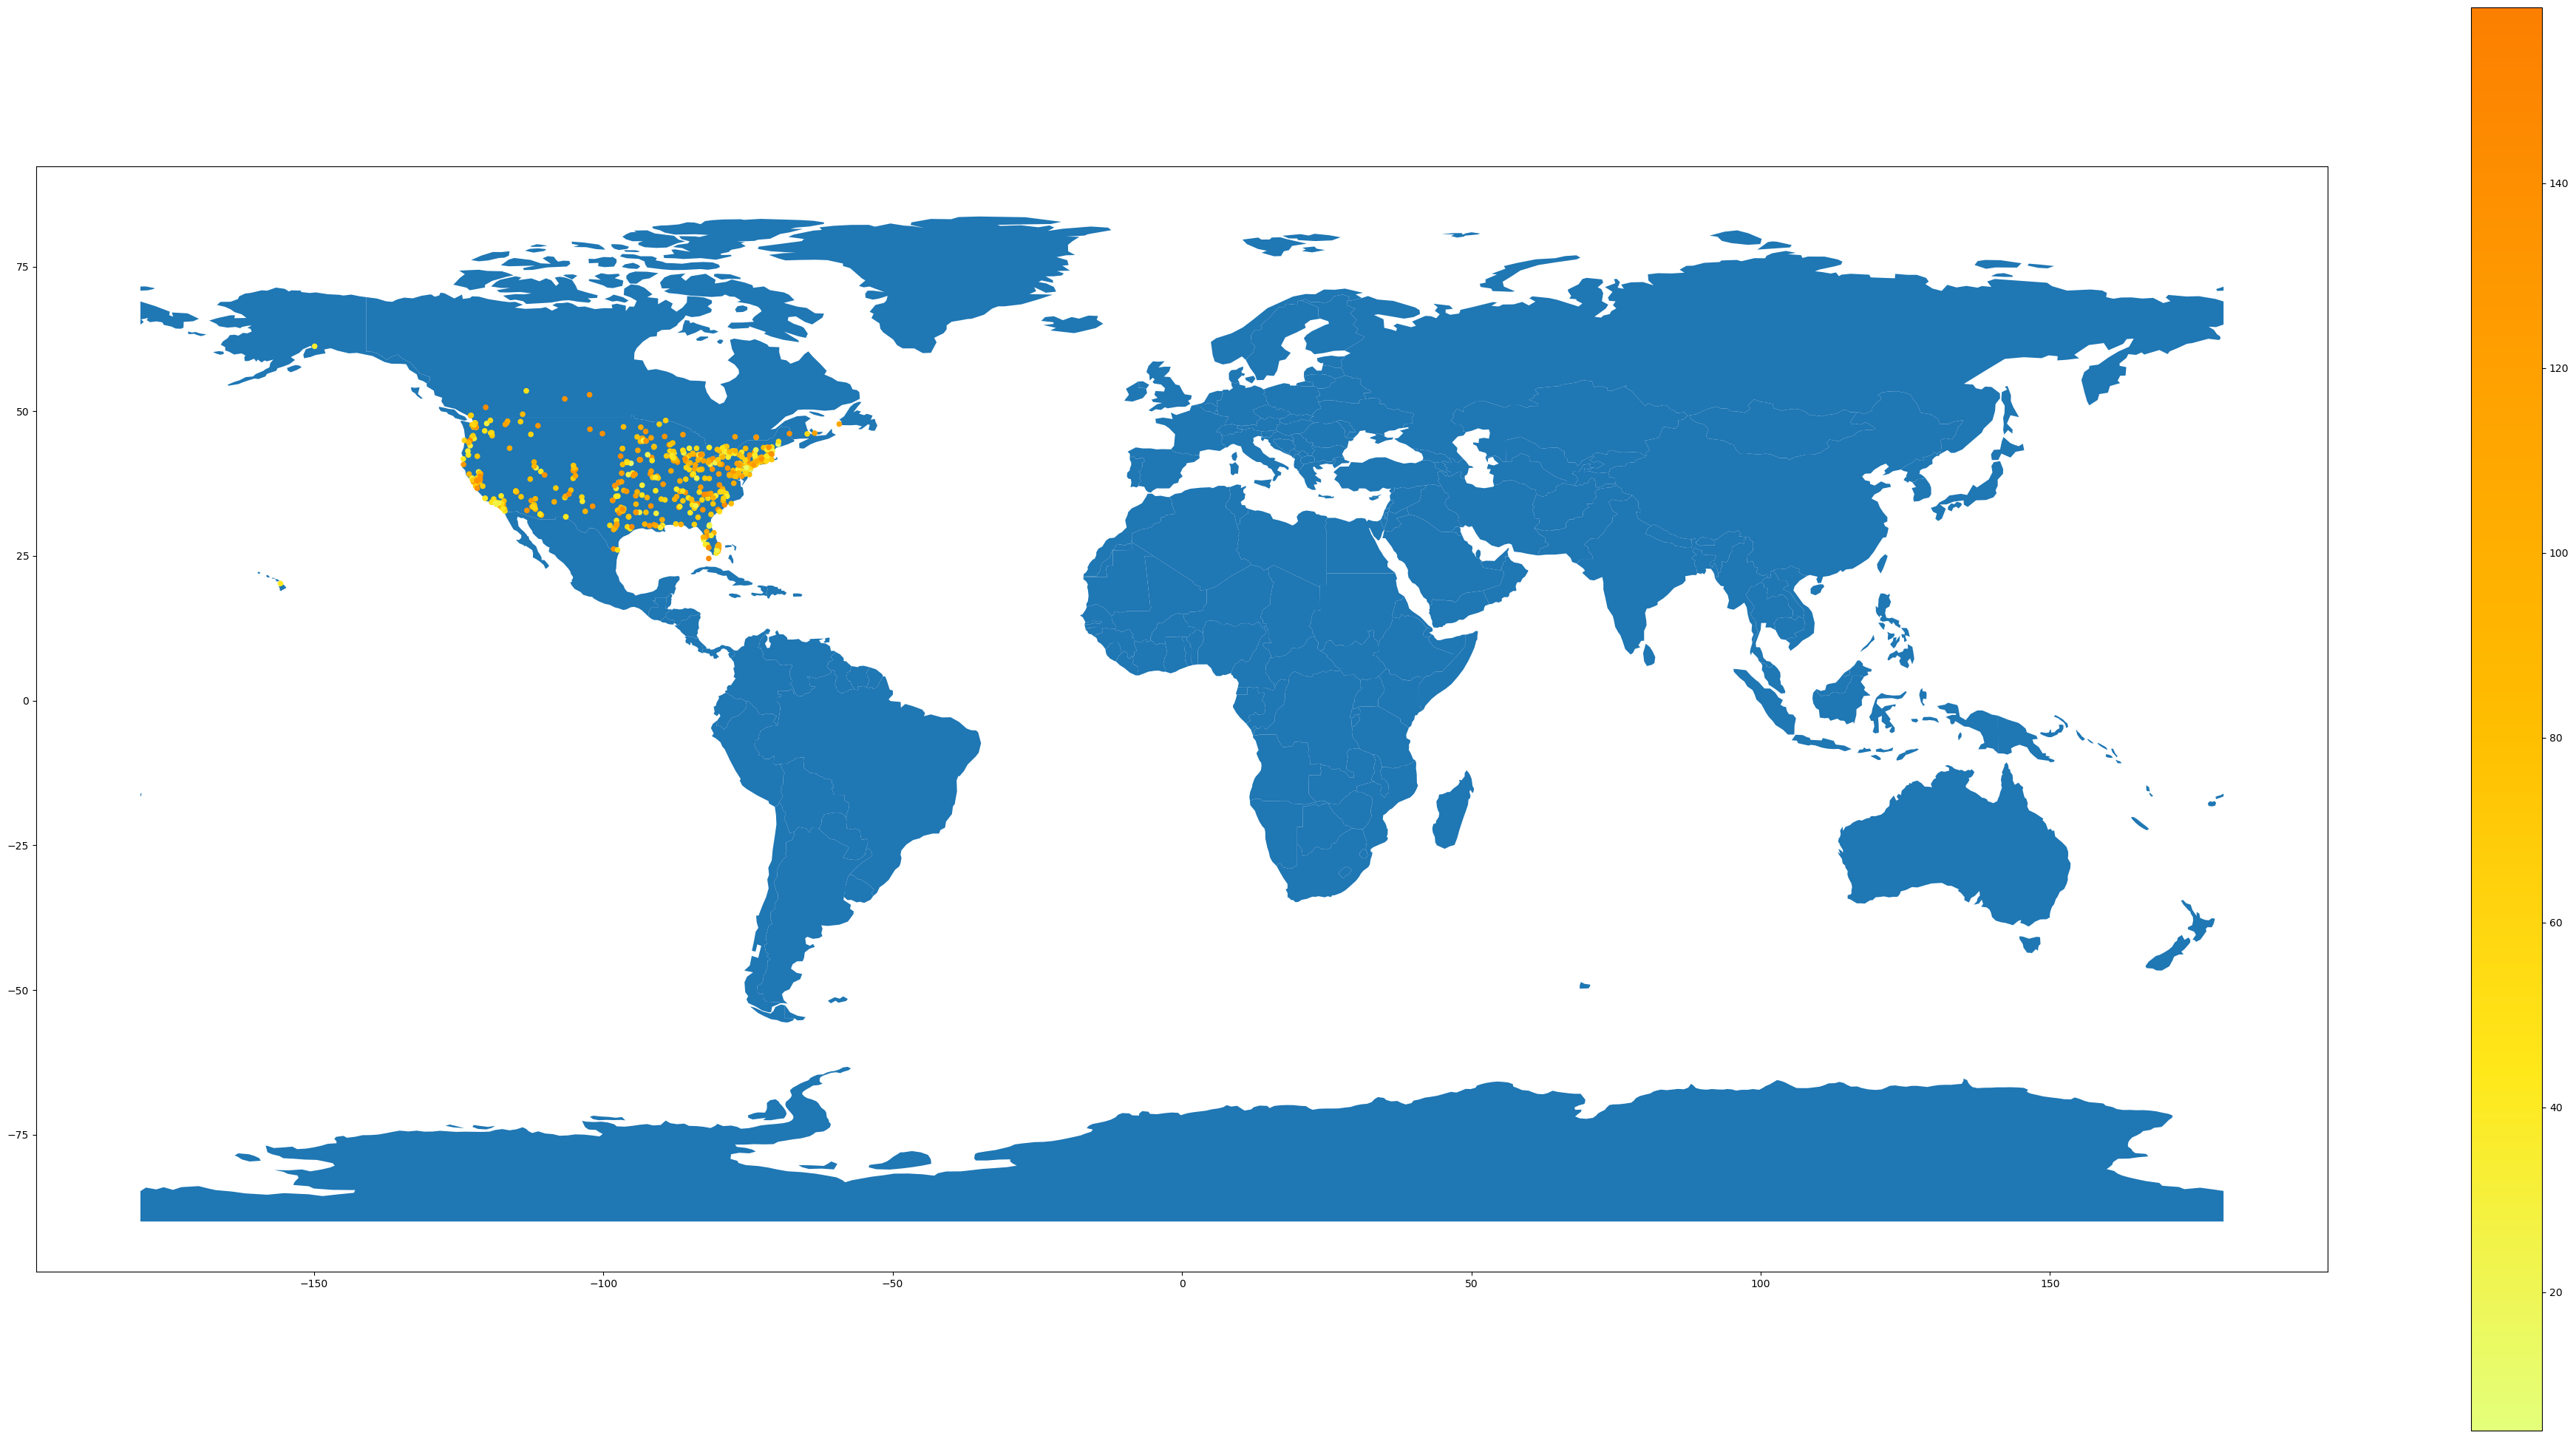

In [15]:
# teardrops

# geopandas - using subset data above
geometry = [Point(xy) for xy in zip(teardrops['longitude'], teardrops['latitude'])]
gdf = GeoDataFrame(teardrops, geometry=geometry)   

# This is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(50, 25)), marker='o', column='comment_length', cmap='Wistia', markersize=20, legend=True);

## K. Koble
### Shape v Duration

Observations under 60 minutes, sample of 20,000/80,000.

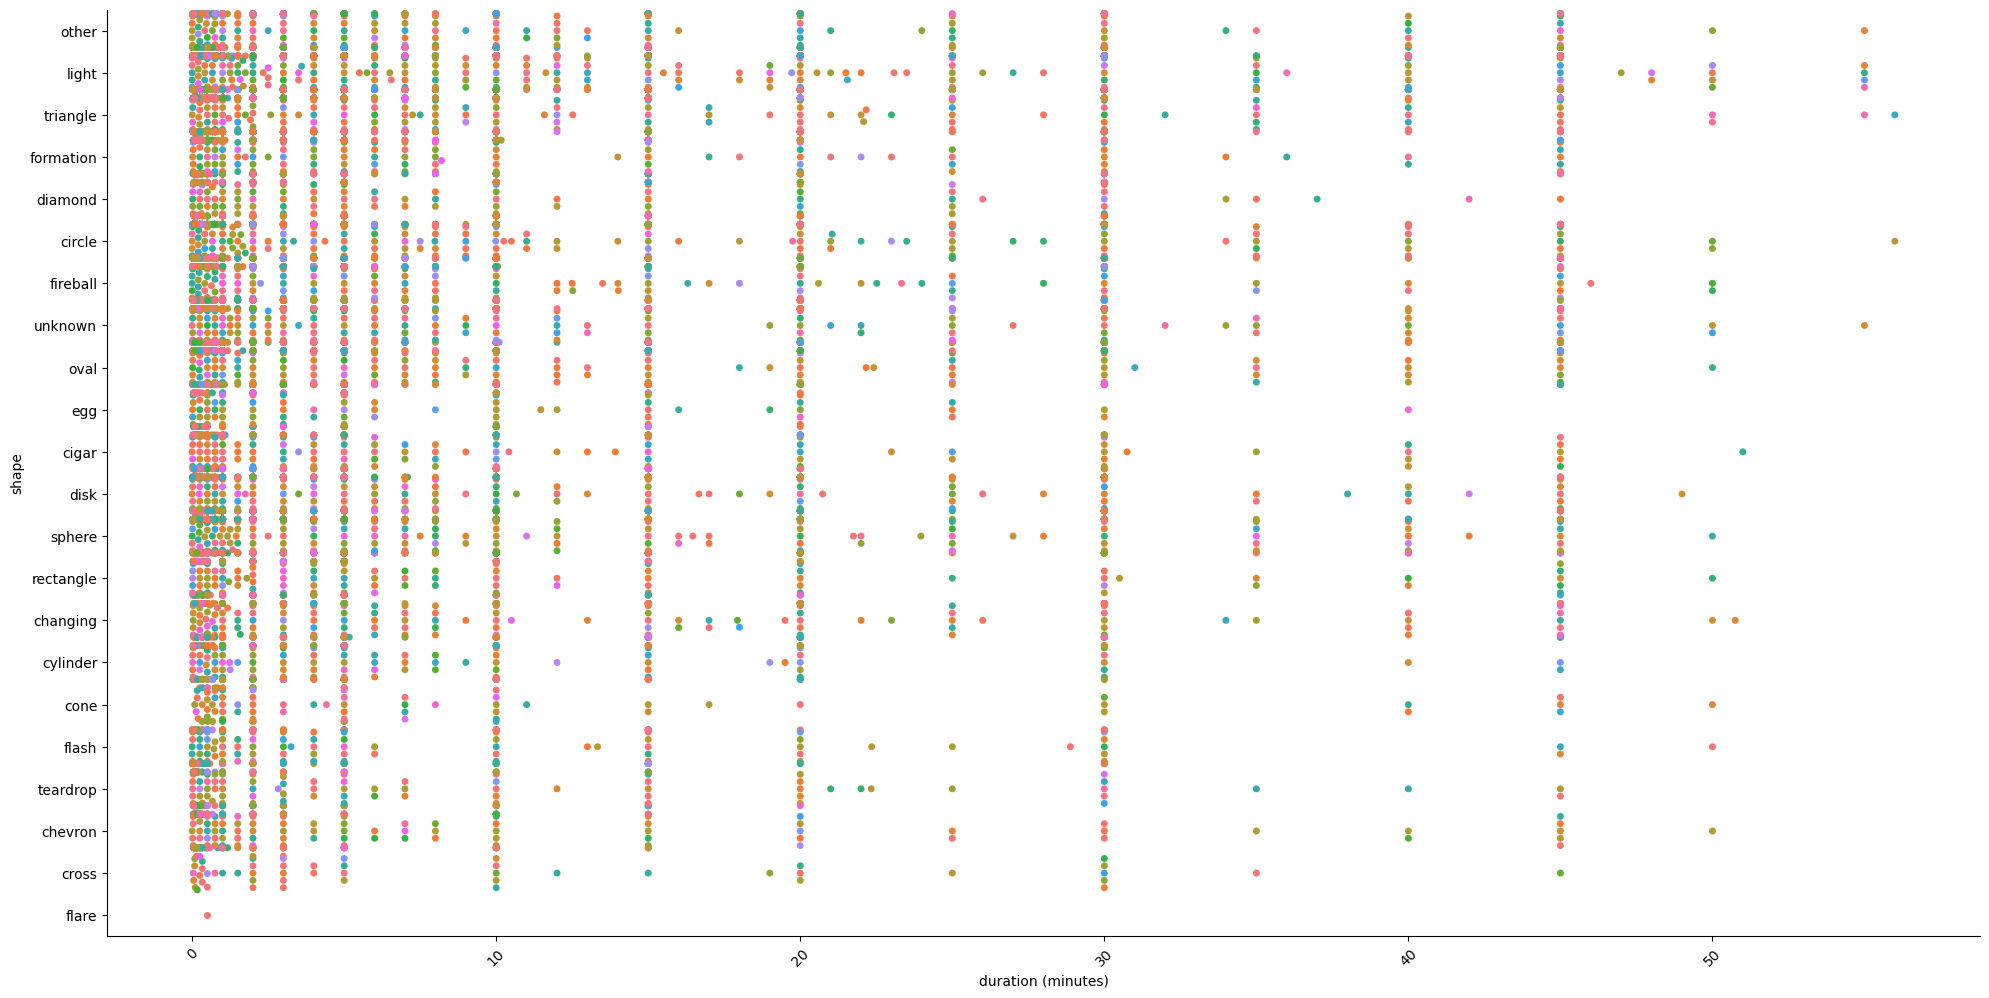

In [16]:
# under 60mins, shape vs duration
sns.catplot(data=df_under60.sample(20000), x="duration (minutes)", y="shape", hue="city", kind="swarm", height=10, aspect=2, legend=False)
plt.xticks(rotation=45)
plt.show()

### City vs Shape
Observations under 100 minutes, sample of 1,000/80,000.

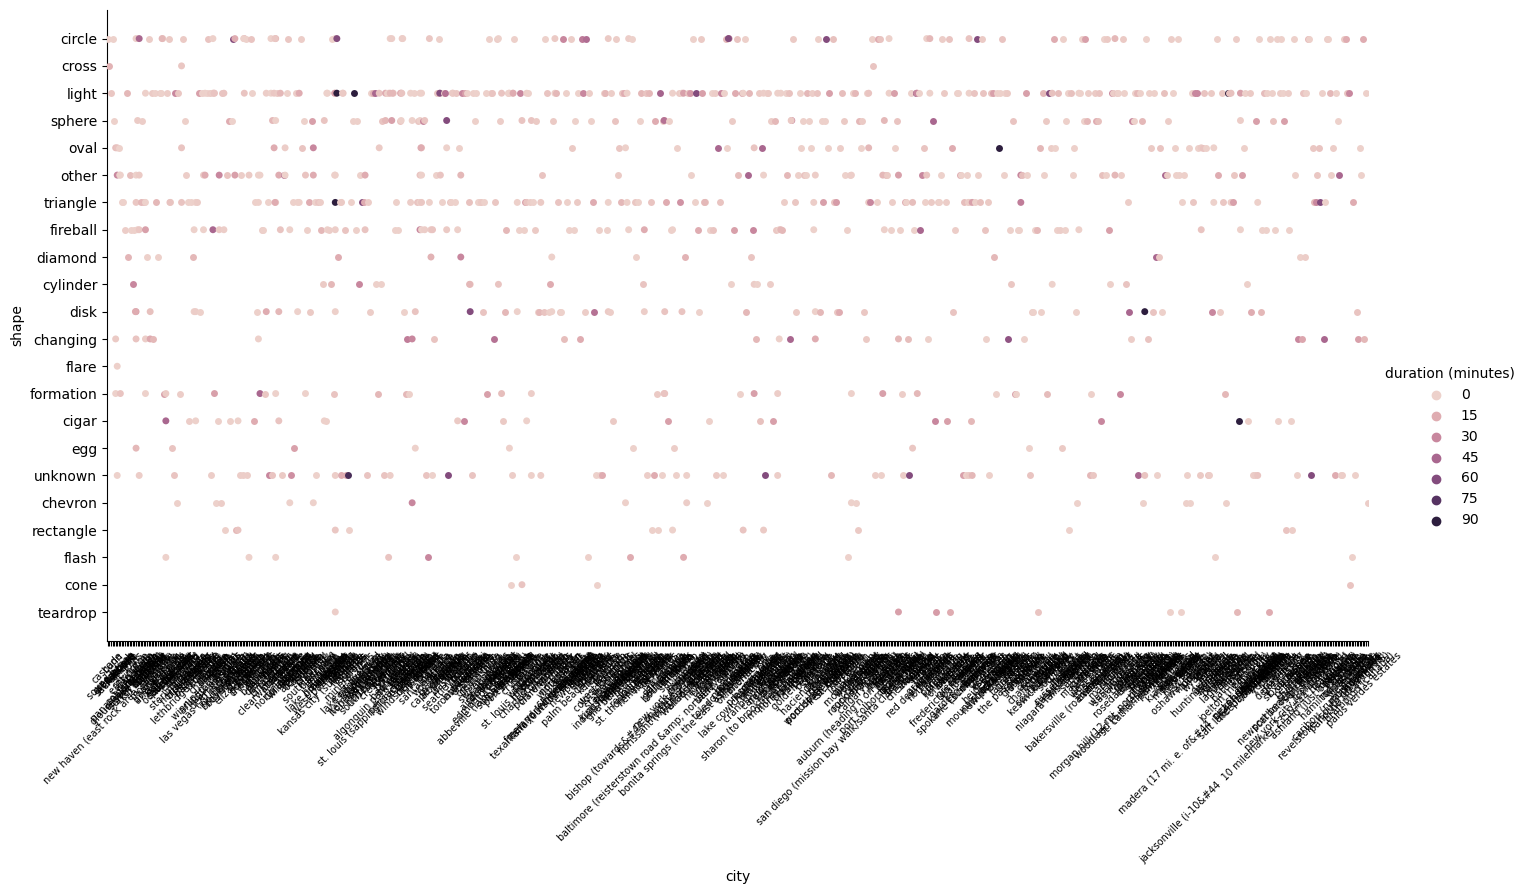

In [17]:
# under 60mins, city vs shape
sns.catplot(data=df_under100.sample(1000), x="city", y="shape", hue="duration (minutes)", kind="swarm", height=7, aspect=2, cmap='Blues')
plt.xticks(rotation=45)
plt.show()

## Stats
### Countries

In [18]:
# Groupby by country
country = df.groupby("country")

# Summary statistic of all countries
country.describe().style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '8px'})

### States

In [19]:
# Groupby by state
state = df.groupby("state")

# Summary statistic of all countries
state.describe().head(15).style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '8px'})

### Shapes

In [20]:
# Groupby by country
shape = df.groupby("shape")

# Summary statistic of all countries
shape.describe().style.background_gradient(cmap ='coolwarm').set_properties(**{'font-size': '8px'})

## Word Cloud

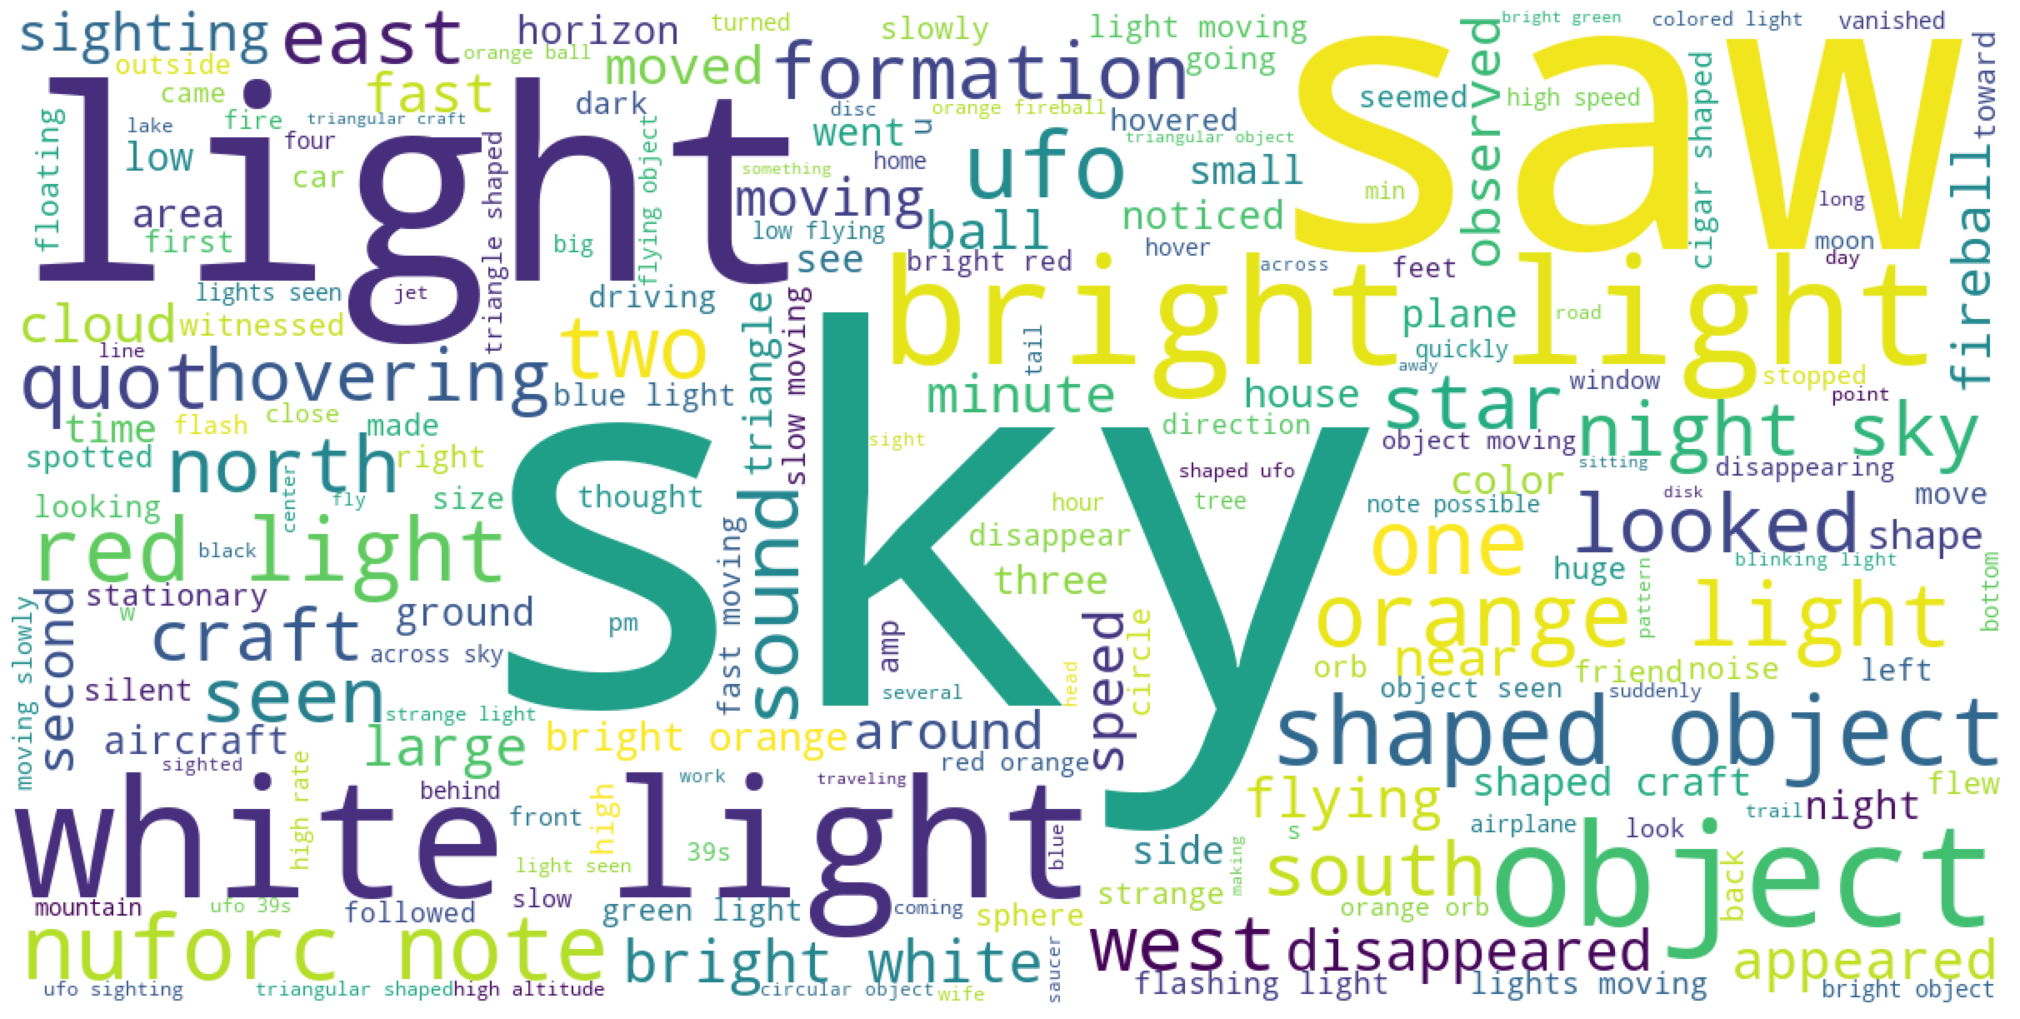

In [21]:
# in the clouds
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.comments:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 7).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize=(25,10), facecolor='None')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### More coming very soon... stand by.
### Stop here - still needs work. Busy week ahead, so standby for updates ;)

# Data Science

# AI - Implementation

# ML - Implementation

In [22]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

# encoding
from sklearn.preprocessing import LabelEncoder

def encode(df):
    lb_make = LabelEncoder()
    columns = df.columns.values.tolist()
    df_encoded = df[columns].copy()

    # categorize/encode
    for i in columns:
        df_encoded[i] = lb_make.fit_transform(df[i])

    # encoded
    return df_encoded


# encoded variable re-mapping
def encoding_remap(df, df_encoded, target):
    
    X_test = X_y_sets(df, target)[0][0]
    
    remap = pd.merge(df_encoded.loc[df_encoded.index.isin(X_test.index.values)][target].reset_index(),
              df.loc[df.index.isin(X_test.index.values)][[target]].reset_index(),on=['index'])
    
    remap[target] = [str(remap[f'{target}_y'][i]) for i,v in remap[f'{target}_x'].items()]
    remap['index'] = np.array([str(remap[f'{target}_x'][i]) for i,v in remap[f'{target}_x'].items()]).astype(int)
    remap=remap[[target,'index']]
    remap = remap.set_index('index').drop_duplicates().sort_values('index')
    
    return remap


# pairplot
import seaborn as sns
def pairplot(df, target):
    return sns.pairplot(df.sample(int(len(df/10000))),hue=target)
    
    
# create X,y variables for ML
from sklearn.model_selection import train_test_split
def X_y_sets(df, target):
    X = df.dropna().drop(columns=[target]).copy()
    y = df.dropna()[target].ravel().copy()
    
    return train_test_split(X, y, test_size=0.33, random_state=42), X, y

## Test Classifier Against Variable Target
### Steps

1. User inputs choice of target variable.
2. Machine chooses random data point in set of data, call it "use-case".
3. Encode randomly generated use case for ML.
4. Classify against present data.
5. Output predicted target value.

If the machine's prediction is wrong, start again from the cells below this.

#### 1. User inputs choice of target variable.

In [43]:
# construction of ML dataframes
target = 'verified'

# copy
a = df[['city','state','country','latitude',#'comments',\
        'longitude','year_month','comment_length','verified']].copy()

# for the sake of computationa efficiency
a = a.head(10000)

# find random sample & save index for defining an encoded use-case
from random import randrange
idx = randrange(len(a))

#### 2. Machine chooses random data point in set of data, call it "use-case".

In [44]:
# print random configuration item
print("\nThis is a randomly chosen subject we will try to predict.")
b = pd.DataFrame(a.loc[idx]).T
print(f"\nTarget:'{target}' value is ",b.reset_index()[target][0])

# store sol'n
solution = int(b.reset_index()[target][0])

# print data point
b

# if this cell fails, try it again from step 1 - you ran into a null variable (i'll fix that soon enough)


This is a randomly chosen subject we will try to predict.

Target:'verified' value is  3


city state country   latitude   longitude year_month comment_length  \
699  snohomish    wa      us  47.913056 -122.096944    2002-10            104   

    verified  
699        3

#### 3. Encode randomly generated use case for ML

In [45]:
# categorize/encode entire dataframe(a)
c = encode(a)
print("\nOriginal dataframe encoded.\n")
c.head(10)


Original dataframe encoded.



city  state  country  latitude  longitude  year_month  comment_length  \
0   3166     55        3       240       1205          58             131   
3   1026     55        3       187       1333          55             134   
4   1736     12        3        17          9          55             150   
5    424     54        3      1449       2909          85             134   
7   2573      8        3      2760       4071          11             109   
8   2770      2        3       709       2292          99             115   
9   1994     10        3       294       2763          70              92   
10  1509      6        3       824        537          52              91   
11   410     30        3      1159       2804          94              89   
12   255     40        3      2559       4053          18              36   

    verified  
0          0  
3          1  
4          0  
5          2  
7          1  
8          1  
9          2  
10         2  
11         2  
12         1

### Feature importance - determines best pair of target variable & classifier.

In [46]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# classifier iteration
def classification_feat_importance(df_encoded):
    
    # iterate through each column variable as classification targets
    for target in df_encoded.columns.values:
        X = df_encoded.drop(columns=[target]).copy()
        y = df_encoded[target].ravel().copy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
    
        # classifiers
        #clf1 = GradientBoostingClassifier(criterion="friedman_mse", init=None, learning_rate=0.3338, loss='deviance', max_depth=19, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=500, random_state=42, subsample=1.0, verbose=1, warm_start=False).fit(X_train, y_train)
        #clf2 = GradientBoostingClassifier(criterion="squared_error", init=None, learning_rate=0.2222, loss='deviance', max_depth=19, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=500, random_state=42, subsample=1.0, verbose=1, warm_start=False).fit(X_train, y_train)
        clf3 = RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42).fit(X_train, y_train)
        clf4 = ExtraTreesClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
        clf5 = AdaBoostClassifier(n_estimators=8000, random_state=42).fit(X_train, y_train)
        clf6 = MLPClassifier(alpha=1, max_iter=500).fit(X_train, y_train)
        #clf7 = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)
        classifiers = [
                       #clf1, 
                       #clf2, 
                       clf3, 
                       clf4, 
                       clf5,
                       clf6,
                       #clf7
                      ]

        for classifier in classifiers:
            results = []
            #
            results.append({"classifier":str(classifier).split("(")[0],"target":target,"test_score":classifier.score(X_test, y_test)})
            for i in results:
                if target == 'verified':
                    print("\nClassifier:",str(classifier).split("(")[0],"\nTarget:",target,"\nScore:",classifier.score(X_test, y_test))
        
        #test_matrix = confusion_matrix(y_test, clf.predict(X_test))    
        
    return pd.DataFrame(results),test_matrix

print("To analyze which target-classifier would yield the best results: \nUncomment (#) the code below.")

To analyze which target-classifier would yield the best results: 
Uncomment (#) the code below.


In [32]:
#classification_feat_importance(c)[0]

#### Pairplot

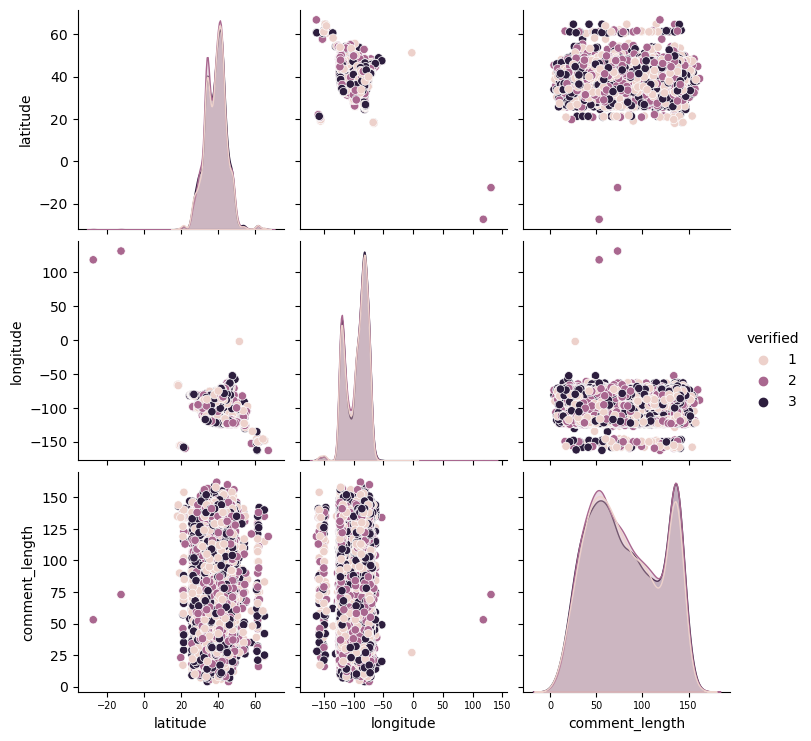

In [76]:
# 'comments' - out
sns.pairplot(a[['city','state','country','latitude','longitude','year_month','comment_length','verified']].copy(),hue=f'{target}')

##### Encoded Data Entry Without Target Variable

In [47]:
# print encoded item
use_case = pd.DataFrame(c.loc[idx]).T.drop(columns=[target]) 

#c

# print encoded item w/out target info
data = c.drop(columns=[target]) 

print("\nThis is our encoded use-case.\n")

use_case


This is our encoded use-case.



city  state  country  latitude  longitude  year_month  comment_length
699  3314     59        3      4191        285          41             100

### Generate X-matrix & Target Vector

#### 4. Classify against present data.

In [48]:
# create X,y variables for ML
# save trainer
print("\nResetting train data...\nCreating X-matrix & y-vector for classification.")
trainer = c.loc[c.index!=idx].copy()
X, y =  trainer.drop(columns=[target]), trainer[target].ravel()
X_train, X_test, y_train, y_test = X_y_sets(trainer, target)[0]


Resetting train data...
Creating X-matrix & y-vector for classification.


#### This is an example of the encoded X_train set.

In [49]:
X_train.head().reset_index(drop=True)

city  state  country  latitude  longitude  year_month  comment_length
0  2224     10        3        29       3227         112             134
1  1537     10        3        31       3205          98              46
2  2470     40        3      2589       3970          16             137
3  3211      4        3       687        848           2             130
4   897     10        3        67       3253         143             100

#### These are the first 5 values of the encoded y_train


In [50]:
y_train[0:5]

array([1, 2, 2, 2, 2])

### Decode Remapping

#### The cell below remaps the encoded values back to their original form (e.g. the report/sightings data)

In [51]:
# encoded variable re-mapping
# specific to our current target choice
d = encoding_remap(a, c, target)
print("\nDecoding our encoded dataframe to correlate with the initial randomly chose subject.\n")


Decoding our encoded dataframe to correlate with the initial randomly chose subject.



### Let's test various classical ML classifiers to find the best model to use.

### Use Classifier To Predict Target Value

The cell below runs the classifier to predict the our subject's targeted variable.

The results using AdaBoost are NOT robust. If you have the time to test the confidence of each classifier, please feel free to uncomment any of the classifiers specified above.

In [54]:
print("\nLive prediction\n")

# choose classifier
#clf = GradientBoostingClassifier(criterion="friedman_mse", init=None, learning_rate=0.3338, loss='deviance', max_depth=19, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=500, random_state=42, subsample=1.0, verbose=1, warm_start=False).fit(X_train, y_train)
#clf = GradientBoostingClassifier(criterion="squared_error", init=None, learning_rate=0.2222, loss='deviance', max_depth=19, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_samples_split=120, min_weight_fraction_leaf=0.0, n_estimators=500, random_state=42, subsample=1.0, verbose=1, warm_start=False).fit(X_train, y_train)

# these ones run just a little more efficiently for now
#clf = RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42).fit(X_train, y_train)
#clf = ExtraTreesClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
clf = AdaBoostClassifier(n_estimators=8000, random_state=42).fit(X_train, y_train)
#clf = MLPClassifier(alpha=1, max_iter=500).fit(X_train, y_train)
#clf = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)

print()
print("Test score: ",clf.score(X_test, y_test))
print()
prediction = clf.predict(use_case)[0]
print(f"Prediction {target} index:",prediction)

# print decoded prediction
print("\nPrediction Decoded")
e = d[d.index == prediction]
e


Live prediction


Test score:  0.33666666666666667

Prediction verified index: 2

Prediction Decoded


verified
index         
2            3

In [71]:
solved = int(e.verified[e.index[0]])
if solution == solved:
    print(f"\nYAYYY!\n\nThe machine's prediction against target variable '{target}' was correct!\n")
else:
    print("\nBooOo!\nThe machine's prediction was incorrect :(")


YAYYY!

The machine's prediction against target variable 'verified' was correct!



# Conclusion

# Contributors & Collaborators

## 🌍A Collaborative Effort🌎

Inspired by: [Mr. Tim Ventura](https://www.youtube.com/channel/UCl1ewEFZwBOTU2I_f0XiSUA) & all you nerdy UAP enthusiasts out there. Let's take this interstellar 🚀 and BEYOND! 

Big thanks to *Kevin Kolbe* for his continuous support & unwavering dedication to presenting only what's true - most importantly for always providing honest feedback.

| [Don's LinkedIn](https://www.linkedin.com/in/dontadaya/) | [Tim's LinkedIn](https://www.linkedin.com/in/timothyventura/) | [Gary's LinkedIn](https://www.linkedin.com/in/garv-gary-van-stephenson-963ba36/) | [Omariba's LinkedIn](https://www.linkedin.com/in/omariba-collins-b28b841b9/) |

### Let's all say thanks to [NUFORC](https://nuforc.org/databank/) for sharing the data!
### And most especially a tremendous applause to [Mr. Omariba Collins](https://www.linkedin.com/in/omariba-collins-b28b841b9/) for bringing this phat csv into Kags. 

Feel free to fork, cite, manipulate, scrutinize, comment, and provide insights you deem worthy.

# Notes & Recommendations


Also, look into the latest updates from the National Intelligence Council 
[Assessment of Anomalous Health Incidents](https://www.dni.gov/files/ODNI/documents/assessments/Updated_Assessment_of_Anomalous_Health_Incidents.pdf) regarding anomalous health incidents. Or just see the [latest releases](https://www.dni.gov/index.php/newsroom/reports-publications/reports-publications-2023) from The ODNI to stay informed on all matters of preserving national security. 

### G. Stephenson
Try adding a time sort too to look for correlating events and to possibly form tracks from multiple sightings of the same object. 

Tracks will be especially challenging as these objects are non-ballistic & non-aerodynamic, and have very large spatial 'windows' from sample to sample, i.e. can jump all over the place. So I would recommend starting with a time sort only, and see what the data tells you.


### K. Kolbe
Should exclude shape words from comment counts - especially lights.

(shape vs duration) & (city v shape)


cmap
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter',




https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77

-OFFICE OF THE DIRECTOR OF NATIONAL INTELLIGENCE-

[2022 Annual Report on Unidentified Aerial Phenomena](https://www.dni.gov/files/ODNI/documents/assessments/Unclassified-2022-Annual-Report-UAP.pdf)

APPENDIX B: AARO ESTABLISHMENT OF OFFICE

...

(b) Duties. 

The duties of the Office (...) shall include the following:

(1) Developing procedures to *synchronize and standardize* the collection, reporting, and analysis of incidents, including adverse physiological effects, regarding unidentified aerial phenomena across the Department of Defense and the Intelligence Community.

(2) Developing *processes and procedures* to ensure that such incidents from each component of the Department and each element of the Intelligence Community are reported and incorporated in a *centralized* repository.

(3) Establishing procedures to *require the timely and consistent reporting of such incidents*.

(4) Evaluating links between unidentified aerial phenomena and adversarial foreign governments, other foreign governments, or nonstate actors.

(5) Evaluating the threat that such incidents present to the United States.

(6) Coordinating with other departments and agencies of the Federal Government, as appropriate, including the Federal Aviation Administration, the National Aeronautics and Space Administration, the Department of Homeland Security, the National Oceanic and Atmospheric Administration, and the Department of Energy.

(7) Coordinating with allies and partners of the United States, as appropriate, to better assess the nature and extent of unidentified aerial phenomena.

(8) Preparing reports for Congress, in both classified and unclassified form, including under section (i).



(2) Elements. Each report under paragraph (1) shall include, with respect to the year covered by the report, the following information:

(A) All reported unidentified aerial phenomena-related events that occurred during the one-year period.

(B) All reported unidentified aerial phenomena-related events that occurred during a period other than that one-year 
period but were not included in an earlier report.

(C) An analysis of data and intelligence received through each reported unidentified aerial phenomena related event.

(D) An analysis of data relating to unidentified aerial phenomena collected through: (i) Geospatial intelligence;
    (ii) Signals intelligence;
    (iii) Human intelligence; and
    (iv) Measurement and signature intelligence.

(E) The number of reported unidentified aerial phenomena over restricted air space of the United States during the one-year period.

(F) An analysis of such incidents identified under subparagraph (E).

(G) Identification of potential aerospace or other threats posed by unidentified aerial phenomena to the national security of the United States.

(H) An assessment of any activity regarding unidentified aerial phenomena that can be attributed to one or more adversarial foreign governments.

(I) Identification of any incidents or patterns regarding unidentified aerial phenomena that indicate a potential adversarial foreign government may have achieved a breakthrough aerospace capability.

(J) An update on the coordination by the United States with allies and partners on efforts to track, understand, and address unidentified aerial phenomena.

(K) An update on efforts underway on the ability to capture or exploit discovered unidentified aerial phenomena.

(L) An assessment of any health-related effects for individuals that have encountered unidentified aerial phenomena.

(M) The number of reported incidents, and descriptions thereof, of unidentified aerial phenomena with military nuclear assets, including strategic nuclear weapons and nuclear- powered ships and submarines.

(N) In consultation with the Administrator for Nuclear Security, the number of reported incidents, and descriptions thereof, of unidentified aerial phenomena associated with facilities or assets associated with the production, transportation, or storage of nuclear weapons or components thereof.

(O) In consultation with the Chairman of the Nuclear Regulatory Commission, the number of reported incidents, and descriptions thereof, of unidentified aerial phenomena or drones of unknown origin associated with nuclear power generating stations, nuclear fuel storage sites, or other sites or facilities regulated by the Nuclear Regulatory Commission.

(P) The names of the line organizations that have been designated to perform the specific functions under subsections 

(c) and (d), and the specific functions for which each such line organization has been assigned primary responsibility.

________________________________________________________________

_________________________________________________________________________